### Prepare Notebook
Install requirements, import packages

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
try:
    import google.colab
    repo_path = 'dspy'
    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)

import pkg_resources
if not "dspy-ai" in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    !pip install dspy-ai
    !pip install openai~=0.28.1
    !pip install -e $repo_path

In [ ]:
%%capture
!pip install langchain openai pillow langchain_openai

In [ ]:
import dspy
from dspy.predict import Retry
# from dspy.datasets import HotPotQA
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
from dspy.evaluate.evaluate import Evaluate
from dspy.primitives.assertions import assert_transform_module, backtrack_handler

from langchain.chains import TransformChain
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langchain import globals
from langchain_core.runnables import chain

In [ ]:
import sys
import os
import regex as re
import json
import base64

from PIL import Image
import requests
from io import BytesIO

### Generate Image Description
GPT4, langchain

In [ ]:
def load_image(inputs: dict) -> dict:
    """Load image from file and encode it as base64."""
    image_path = inputs["image_path"]

    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    image_base64 = encode_image(image_path)
    return {"image": image_base64}

@chain
def image_model(inputs: dict) -> str | list[str] | dict:
 """Invoke model with image and prompt."""
 model = ChatOpenAI(temperature=0.5, model="gpt-4-vision-preview", max_tokens=1024)
 msg = model.invoke(
             [HumanMessage(
             content=[
             {"type": "text", "text": inputs["prompt"]},
             {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}"}},
             ])]
             )
 return msg.content

def get_image_informations(image_path: str) -> dict:
   vision_prompt = f"""
   Given the image provide the description
   """
   vision_chain = load_image_chain | image_model
   return vision_chain.invoke({'image_path': f'{image_path}',
                               'prompt': vision_prompt})


load_image_chain = TransformChain(
    input_variables=["image_path"],
    output_variables=["image"],
    transform=load_image
)

#### Results

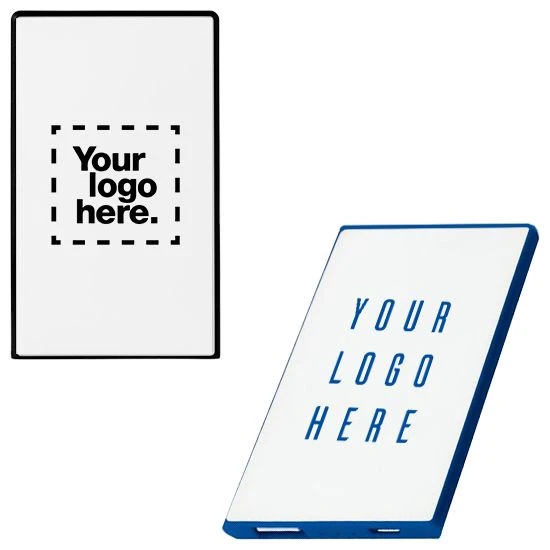

In [ ]:
image_url = 'https://www.logotech.com/media/catalog/product/cache/181292fb76a1b1d8d078d7fe975030bd/s/l/slim_credit_card_2000_mah_power_bank_103719_1_c7b4.webp'
response = requests.get(image_url)

img = Image.open(BytesIO(response.content))
img.save("test.png")

img

In [ ]:
result = get_image_informations("test.png")
result

The image shows two rectangular cards or placards. The one on the left is in a portrait orientation, appears to be white, and has a dashed-line rectangle in the center with the text "Your logo here." inside it. The one on the right is tilted at an angle, has a blue border, and also features the text "YOUR LOGO HERE" in blue capital letters, which suggests that these are mock-ups for branding or promotional purposes where a company or individual can add their own logo or design in the designated space.


### Fine Tune
GPT3.5-turbo, DSPy

In [ ]:
turbo = dspy.OpenAI(model='gpt-3.5-turbo-0613', max_tokens=1024)
dspy.settings.configure(lm=turbo, temperature=0.2)

#### Dataset Preparation

In [ ]:
dataset = [
    {
        "description": """Digital display LED Power Bank - 10000 mAH 1.Material: Aluminium + Plastic 2.BatteryCapacity:10000 mAh3.Model Size:152*77*10mm; 4.Connect: Double USB output5.Input:5 V / 2.1A; 6.Output:5 V / 2.1A ; 7.Cycle count : 500+ 8.Imprinting method : Fullcolor printing / Silk screen printing 9.Stock color:Black,Blue,Red,Rose Gold.""",
        "FAQ": """<p>The Ultra Thin Wireless Magnetic Mini Power Bank is the perfect blend of power,portability, and branding! This sleek power bank is designed to keep your devicescharged without adding bulk to your bag. Its magnetic feature securely attaches to yourphone for easy charging wherever you are!</p><p>Made with high-quality materials, thispower bank ensures durability and reliability for all your charging needs. The 5000mAhbattery capacity provides ample power to keep you connected throughout the day. WithLogotech, you can customize this power bank with your branding to create a uniquepromotional item! These power banks will leave a lasting impression on your clients oremployees.</p><p>Stay connected and promote your brand with the Ultra Thin WirelessMagnetic Mini Power Bank!</p><h2>Frequently Asked Questions:</h2><h3>Q: How willmy logo be added to this product?</h3><p>A: Your logo can be added with full-color orscreen printing.</p><h3>Q: What is the minimum order quantity for thisproduct?</h3><p>A: The minimum order quantity is 100 units.</p><h3>Q: What are thecommon uses for this product once it’s branded?</h3><p>A: This versatile charger isperfect for professionals on the go, corporate events, tech giveaways, customer loyaltyrewards, and as a practical accessory for remote employees to stayconnected.</p><h3>Q: What material is this product made with?</h3><p>A: Thisproduct is made from a combination of aluminum and plastic.</p><h3>Q: What colorsare available for this product?</h3><p>A: This product comes in black, blue, red, and
white.</p><h3>Q: Can this power bank charge multiple devices at once?</h3><p>A: Itsdouble USB output charges multiple devices simultaneously, offering a convenientsolution for keeping all your devices powered.</p><h3>Q: Is this power bank suitable forall types of smartphones?</h3><p>A: Yes, its universal charging capability andmagnetic feature make it suitable for a wide range of smartphones.</p>"""
    },
    {
        "description": """Type:Wireless Charger, 3 in 1 Wireless Charging Station, Magnetic, Desktop Charger,Fast Charger, Magnetic Wireless Charger Name:Top Quality 15W 3-in-1 MagneticWireless Charger 3 in 1 Charger Dock Usage:Household Electrical AppliancesMaterial:ABS+Rubber oil, ABS + rubber oil. Complies with CE. 5" L x 4.61" W x 2.8" H.""",
        "FAQ": """<p>Streamline your charging experience with 3 in 1 Magnetic Wireless Charger Stand!This innovative charger combines convenience with efficiency and brand promotion, allin one sleek device.</p><p>With the ability to wirelessly charge your phone, watch, andearbuds simultaneously, this charger is a game-changer. The magnetic feature ensuresyour devices stay securely in place while charging, preventing any accidentalslips.</p><p>Customize this charger with your logo or message to create a uniquemarketing product that will impress your clients and employees! Not only will theyappreciate the practicality of this charger, but they will also be reminded of your brandwhenever they power up their devices.</p><p>Promote your brand with this cutting-edge charging stand!</p><h2>Frequently Asked Questions:</h2><h3>Q: How will mylogo be added to this product?</h3><p>A: Your logo will be added with full-colorprinting.</p><h3>Q: What is the minimum order quantity for this product?</h3><p>A:The minimum order quantity is 100 units.</p><h3>Q: What are the common uses forthis product once it’s branded?</h3><p>A: Once branded, this versatile charging stand isperfect for office desks, home use, promotional giveaways, corporate gifts, tech events,and brand awareness campaigns.</p><h3>Q: What material is this product madewith?</h3><p>A: This product is made with quality plastic.</p><h3>Q: What colors areavailable for this product?</h3><p>A: This product is available in black.</p><h3>Q: Howdoes the magnetic feature enhance the charging experience?</h3><p>A: The magneticfeature securely holds your devices in place during charging, eliminating the risk of slipsor falls.</p><h3>Q: What devices is this charger compatible with?</h3><p>A: Thischarger is compatible with a wide range of phones, watches, and earbuds that supportwireless charging.</p>"""
    },
    {
        "description": """This will keeps your Air-Tag safely inside the secure holder, while its strong and flexiblestrap easily attaches to your luggage, purse, and other belongings. Durable Air-Tagkeychain with strap is the perfect way to keep your Apple Air-Tag safe and secure whileon the go. Easily and securely attach an Air-Tag to your key chain, bookbags, luggage, oreven to a pet collar.""",
        "FAQ": """<p>The Air Tag Holder With Strap is the perfect way to keep your Apple Air-Tag safe andsecure on the go! This durable holder ensures your Air-Tag stays securely in place whilethe flexible strap easily attaches to your luggage, purse, or otherbelongings.</p><p>Customize this Air Tag Holder with your logo or brand name tocreate a personalized and practical promotional item! This holder is perfect forbusinesses looking to increase brand visibility and awareness.</p><p>With thisconvenient keychain holder, you will never worry about losing your Air-Tag again. Foradded security, you can attach it to your keychain, bookbag, luggage, or even your pet'scollar.</p><p>Invest in the Air Tag Holder With Strap and give your customers a usefulaccessory they'll appreciate!</p><h2>Frequently Asked Questions:</h2><h3>Q: How willmy logo be added to this product?</h3><p>A: Your logo will be added with full-colorprinting.</p><h3>Q: What is the minimum order quantity for this product?</h3><p>A:The minimum order quantity is 100 units.</p><h3>Q: What are the common uses forthis product once it’s branded?</h3><p>A: Once customized with your logo, thisaccessory can be used for securing and identifying luggage during travel, attaching topersonal items such as purses or backpacks for easy access, or even as a secure tagfor pets' collars for added peace of mind.</p><h3>Q: What material is this productmade with?</h3><p>A: This product is made with plastic.</p><h3>Q: What colors areavailable for this product?</h3><p>A: This product is available in black, brown, andorange.</p><h3>Q: How does this product contribute to customersatisfaction?</h3><p>A: Offering this customized accessory provides your customerswith a practical and stylish solution to keep their valuable items safe.</p>"""
    },
    {
        "description": """High precision touch pen, suitable for all capacitive screen touch devices, elastic penhead and accurate landing point. There is no disconnection, and the touch screen doesnot delay. Don't hurt the screen. Android, IOS and windows systems are universal, with60-80 minutes of charging and 10 hours of service life, Size : 8.9mm *167mm.""",
        "FAQ": """<p>The Universal Capacitance Pen is ideal for businesses looking to elevate their brandpresence! This high-precision touch pen is designed for all capacitive screen touchdevices, ensuring the pen head has an accurate landing point every time. Say goodbyeto disconnections and delays on your touch screen—this pen is compatible withAndroid, iOS, and Windows systems.</p><p>The benefits of this pen are endless—fromincreased brand visibility to associating your brand with cutting-edge technology. With60-80 minutes of charging time and 10 hours of service life, this pen is a reliablecompanion for daily tasks.</p><p>Don't settle for ordinary promotional products—standout with the Universal Capacitance Pen!</p><h2>Frequently AskedQuestions:</h2><h3>Q: What is the minimum order quantity for thisproduct?</h3><p>A: The minimum order quantity is 500 units.</p><h3>Q: What are thecommon uses for this product once it’s branded?</h3><p>A: This high-precision touch
pen can be used for a variety of purposes, including corporate gifts, trade showgiveaways, customer appreciation tokens, and as a functional tool for dailyuse.</p><h3>Q: What material is this product made with?</h3><p>A: This product ismade with high-quality plastic.</p><h3>Q: What colors are available for thisproduct?</h3><p>A: This product is available in black, red, and white.</p><h3>Q: Howlong does the pen last on a single charge?</h3><p>A: The pen offers up to 10 hours ofservice life.</p><h3>Q: What makes this touch pen a better choice compared toothers?</h3><p>A: Unlike ordinary touch pens, this model features an elastic pen headfor accurate use, ensuring no disconnections or delays.</p>"""
    },
    {
        "description":"""Product Color: Black Material: ABS+ Electroplating + Rubber Oil Input Port: USB-CProduct Input: 5V/2A; 9 V / 2 A; 12/1.5 A Product Output: 5W/7.5W/10W/15W ChargingEfficiency: 73% Appearance Parameters: Naked Machine Size 86*71*32mm; Net Weight52 G Packing Parameters: Packing Size 140*103*38mm; The Gross Weight Of 121 G.Complies with CE. 3.386" L x 2.756" W x 1.142" H.""",
        "FAQ":"""<p>When it comes to charging your phone on the go, you need a reliable and efficientsolution. The Rotation Adsorption 15W Magnetic Wireless Quick Car Charger is theperfect solution! This innovative charger combines convenience and speed to keep youpowered up wherever you are. It's also a great promotional tool for yourbrand!</p><p>Made with durable ABS, electroplating, and rubber oil, this charger is builtto last. The USB-C input port allows for quick and easy charging, with output optionsranging from 5W to a super-fast 15W. With a charging efficiency of 73%, you can trustthat your device will be ready to go when you are.</p><p>With custom branding options,you can add your logo or branding for a personalized touch. That will turn this innovativetech device into a top-tier marketing tool! Using a high-tech product like a wireless carcharger as a promotional product will associate your brand with innovation andsophistication.</p><p>Get your brand noticed with the Adsorption Quick CarCharger!</p><h2>Frequently Asked Questions:</h2><h3>Q: How will my logo be addedto this product?</h3><p>A: Your logo will be added with full-color printing.</p><h3>Q:What is the minimum order quantity for this product?</h3><p>A: The minimum orderquantity is 100 units.</p><h3>Q: What are the common uses for this product once it’sbranded?</h3><p>A: Once branded, this magnetic wireless car charger is perfect forcorporate gifts, tech giveaways, trade shows, and as a premium item in loyaltyprograms.</p><h3>Q: What material is this product made with?</h3><p>A: This productis made with high-quality plastic.</p><h3>Q: What colors are available for thisproduct?</h3><p>A: This product is black.</p><h3>Q: How does the magnetic featureenhance the charging process?</h3><p>A: The magnetic feature ensures that yourphone stays securely in place during the charging process, eliminating the risk of it
falling due to bumps or turns.</p><h3>Q: Can this charger accommodate differentphone models?</h3><p>A: Yes, this charger is designed to work with any phone modelthat supports wireless charging.</p>
"""
    }

]

In [ ]:
questions_mask = [[1,1,1,1,1,1,1,0],
                  [1,1,1,1,1,1,1,0],
                  [1,1,1,1,1,1,0,0],
                  [0,1,1,1,1,1,1,0],
                  [1,1,1,1,1,1,1,0]]

In [ ]:
def wrap_tag(string, tag='h3'):
  return f'<{tag}>{string}</{tag}>'


jsonic_dataset = []
for row, data_row in enumerate(dataset):
  json_pairs = {}
  json_pairs["description"] = data_row['description']

  qas = data_row["FAQ"].split('<h3>')
  json_pairs["gold_description"] = qas[0]

  qas_idx = 1
  question_answers = {}
  for i, q_mask in enumerate(questions_mask[row]):
      if i == 1:
        question_answers[f"question{1+i}"] = ""
        question_answers[f"answer{1+i}"] = ""
        qas_idx += 1
        continue
      if q_mask :
          question, answer = qas[qas_idx].split('</h3>')
          qas_idx += 1
          question_answers[f"question{1+i}"] = wrap_tag(question)
          question_answers[f"answer{1+i}"] = answer
      else:
          question_answers[f"question{1+i}"] = ""
          question_answers[f"answer{1+i}"] = ""
  json_pairs["FAQ"] = question_answers
  jsonic_dataset.append(json_pairs)


jsonic_dataset

[{'description': 'Digital display LED Power Bank - 10000 mAH 1.Material: Aluminium + Plastic 2.BatteryCapacity:10000 mAh3.Model Size:152*77*10mm; 4.Connect: Double USB output5.Input:5 V / 2.1A; 6.Output:5 V / 2.1A ; 7.Cycle count : 500+ 8.Imprinting method : Fullcolor printing / Silk screen printing 9.Stock color:Black,Blue,Red,Rose Gold.',
  'gold_description': '<p>The Ultra Thin Wireless Magnetic Mini Power Bank is the perfect blend of power,portability, and branding! This sleek power bank is designed to keep your devicescharged without adding bulk to your bag. Its magnetic feature securely attaches to yourphone for easy charging wherever you are!</p><p>Made with high-quality materials, thispower bank ensures durability and reliability for all your charging needs. The 5000mAhbattery capacity provides ample power to keep you connected throughout the day. WithLogotech, you can customize this power bank with your branding to create a uniquepromotional item! These power banks will leave 

In [ ]:
dspy_dataset = []
for i in range(len(jsonic_dataset)):
  dataset_row = jsonic_dataset[i]
  exmpl = dspy.Example(product_description = dataset_row['description'], gold_description = dataset_row['gold_description'], FAQ = json.dumps(dataset_row['FAQ'])).with_inputs("product_description")
  dspy_dataset.append(exmpl)

In [ ]:
class GenerateFAQ(dspy.Signature):
    """Generate description and FAQ in JSON key-value format with two keys:
    key "description" that include the paraphrased product descripiton and
    key "FAQ" with frequently asked questions witch consist of dictionary of questions and answers with keys "question{number of question}" for question and "answer{number of question}".
    All content created must be high-quality content according to best SEO practices.
    Use a witty tone to attract potential customers.
    Format the description with HTML paragraph code only.
    Do not use emojis under any circumstances.
    Do not use registered trademark symbols under any circumstances.
    Do not start the description with 'Introducing' or 'Looking for'.
    Avoid special characters except for punctuation.
    Fill out the following FAQ and follow these rules:
    Do not use [] brackets for any of the answers under any circumstances.
    All content created must be high-quality content according to best SEO practices.
    For question 1, (If the decoration method is not empty/null, submit question 1 using theprovided decoration methods), (if the decoration method is empty/null, do not submitquestion 1), use the provided decoration methods. Do not use decoration method in youranswer.
    For question 2, use the provided minimum order quantity if provided else leave blank.
    For question 3, generate and separate with commas a few practical common uses forthe promotional product based on the description.
    For question 4, (If the material is not null, submit question 4 using the providedmaterial), (if the material is null, do not submit question 4).
    For question 5, (for all colors except multicolored, submit question 5 using the colorsprovided), (if color group contains multicolored, do not submit question 5).
    For question 6, 7, and 8 add custom questions and answers to the FAQ template that you think will help the customer. Rephrase any information you use from 'description in FAQ. Avoid using the product name in the FAQ
    If the information not given in description leave the answer blank.
    Write a product description, with HTML paragraph code.
    The following is the FAQ format to fill out:
    <h2>Frequently Asked Questions: </h2>
    <h3>How will my logo be added to this product?</h3>
    A:
    <h3>What is the minimum order quantity for this product?</h3>
    A:
    <h3>What are the common uses for this product once it’s branded?</h3>
    A:
    <h3>What material is this product made with?</h3>
    A:
    <h3>What colors are available for this product?</h3>
    A:
    <h3></h3>
    A:
    <h3></h3>
    A:
    <h3></h3>
    A:
    """

    product_description = dspy.InputField()
    description_FAQ = dspy.OutputField(desc='JSON key-value pairs')


class FAQGenerator(dspy.Module):
    def __init__(self):
        super().__init__()
        self.generate_FAQ = dspy.ChainOfThought(GenerateFAQ)

    def forward(self, product_description):
        description_FAQ = self.generate_FAQ(product_description=product_description).description_FAQ
        return dspy.Prediction(description_FAQ = description_FAQ)


faq_generator = FAQGenerator()

#### Prompt Tuning

In [ ]:
def format_checker(faq_string):
    try:
        faqs = json.loads(faq_string)
        if isinstance(faqs, dict) and all(isinstance(key, str) for key, value in faqs.items()):
            return True, faqs
    except json.JSONDecodeError:
        return False, None
    return False, None


class AssessDespcription(dspy.Signature):
    """Assess the quality description"""

    description = dspy.InputField()
    generated_description = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Yes or No")

class AssessQuestion(dspy.Signature):
    """Assess the quality question and answer"""

    QA = dspy.InputField()
    QA_generated = dspy.InputField()
    assessment_question = dspy.InputField()
    assessment_answer = dspy.OutputField(desc="Yes or No")


def plausibility_metric_description(description, generated_description):
    plausibility_question = "Are the descriptions plausible?"
    plausibility_assessment = dspy.Predict(AssessDespcription)(description=description, generated_description=generated_description, assessment_question=plausibility_question)
    plausibility_result = plausibility_assessment.assessment_answer.split()[0].lower() == 'yes'
    score = plausibility_result
    return score

def plausibility_metric_questions(gold_qa, pred_qa):
    plausibility_question = "Are the question and answer plausible?"
    plausibility_assessment = dspy.Predict(AssessQuestion)(QA=gold_qa, QA_generated=pred_qa, assessment_question=plausibility_question)
    plausibility_result = plausibility_assessment.assessment_answer.split()[0].lower() == 'yes'
    score = plausibility_result
    return score


def combined_metric(gold, pred, trace=None):
    QUESTION_NUM = 8
    TOTAL_POSIBLE_SCORE = 12.
    total_score = 0
    _, gold_FAQ = format_checker(gold.FAQ)
    format_valid, dict_faqs = format_checker(pred.description_FAQ)
    total_score += format_valid
    try:
      gold_description = gold.gold_description
      description = dict_faqs.get("description")
      total_score+=1
      description_plausible_score = plausibility_metric_description(gold_description, description)
      total_score += description_plausible_score
    except:
      pass

    try:
      faqs = dict_faqs.get("FAQ")
      total_score+=1
      for i in range(QUESTION_NUM):
        question = faqs[f"question{i+1}"]
        answer = faqs[f"answer{i+1}"]
        total_score += plausibility_metric_questions(f"""Question:{gold_FAQ.get(f"question{i+1}")} Answer:{gold_FAQ.get(f"answer{i+1}")}""", f"Question:{question} Answer:{answer}")
    except:
      pass

    return total_score / TOTAL_POSIBLE_SCORE



In [ ]:
dspy_dataset[4]['FAQ']

'{"question1": "<h3>Q: How will my logo be addedto this product?</h3>", "answer1": "<p>A: Your logo will be added with full-color printing.</p>", "question2": "", "answer2": "", "question3": "<h3>Q: What are the common uses for this product once it\\u2019sbranded?</h3>", "answer3": "<p>A: Once branded, this magnetic wireless car charger is perfect forcorporate gifts, tech giveaways, trade shows, and as a premium item in loyaltyprograms.</p>", "question4": "<h3>Q: What material is this product made with?</h3>", "answer4": "<p>A: This productis made with high-quality plastic.</p>", "question5": "<h3>Q: What colors are available for thisproduct?</h3>", "answer5": "<p>A: This product is black.</p>", "question6": "<h3>Q: How does the magnetic featureenhance the charging process?</h3>", "answer6": "<p>A: The magnetic feature ensures that yourphone stays securely in place during the charging process, eliminating the risk of it\\nfalling due to bumps or turns.</p>", "question7": "<h3>Q: Can th

In [ ]:
teleprompter = BootstrapFewShotWithRandomSearch(metric = combined_metric, max_bootstrapped_demos=3, num_candidate_programs=6)
compiled_faq_generator = teleprompter.compile(student = faq_generator, teacher = faq_generator, trainset=dspy_dataset[:3], valset=dspy_dataset[3:],)

Going to sample between 1 and 3 traces per predictor.
Will attempt to bootstrap 6 candidate sets.
{'description': "<p>High precision touch pen, suitable for all capacitive screen touch devices, elastic penhead and accurate landing point. There is no disconnection, and the touch screen does not delay. Don't hurt the screen. Android, IOS and windows systems are universal, with 60-80 minutes of charging and 10 hours of service life, Size : 8.9mm *167mm.</p>", 'FAQ': {'question1': '<h2>Frequently Asked Questions: </h2><h3>How will my logo be added to this product?</h3>A: We offer various decoration methods such as laser engraving, screen printing, and full-color digital printing to add your logo to this touch pen. Our team of experts will work with you to determine the best method for your specific design and ensure a high-quality result.', 'question2': "<h3>What is the minimum order quantity for this product?</h3>A: The minimum order quantity for this touch pen is 100 units. However, we u

Average Metric: 1.25 / 2  (62.5): 100%|██████████| 2/2 [00:00<00:00, 551.63it/s]


Score: 62.5 for set: [0]
New best sscore: 62.5 for seed -3
Scores so far: [62.5]
Best score: 62.5
{'description': "<p>High precision touch pen, suitable for all capacitive screen touch devices, elastic penhead and accurate landing point. There is no disconnection, and the touch screen does not delay. Don't hurt the screen. Android, IOS and windows systems are universal, with 60-80 minutes of charging and 10 hours of service life, Size : 8.9mm *167mm.</p>", 'FAQ': {'question1': '<h2>Frequently Asked Questions: </h2><h3>How will my logo be added to this product?</h3>A: We offer various decoration methods such as laser engraving, screen printing, and full-color digital printing to add your logo to this touch pen. Our team of experts will work with you to determine the best method for your specific design and ensure a high-quality result.', 'question2': "<h3>What is the minimum order quantity for this product?</h3>A: The minimum order quantity for this touch pen is 100 units. However, we u

Average Metric: 1.25 / 2  (62.5): 100%|██████████| 2/2 [00:00<00:00, 618.13it/s]


Score: 62.5 for set: [3]
Scores so far: [62.5, 62.5]
Best score: 62.5


100%|██████████| 3/3 [00:00<00:00, 340.02it/s]


None
{'description': '<p>Introducing our Top Quality 15W 3-in-1 Magnetic Wireless Charger! This wireless charger is not your ordinary charger - it\'s a versatile charging station that can power up three devices simultaneously. With its sleek and compact design, it\'s the perfect addition to any desktop or nightstand.</p><p>Our 3-in-1 charger is equipped with magnetic technology, ensuring a secure and stable connection between your devices and the charger. No more worrying about misalignment or disconnection while charging. Plus, it supports fast charging, so you can power up your devices in no time.</p><p>Made with high-quality ABS and rubber oil materials, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 5" L x 4.61" W x 2.8" H make it compact enough to fit in any space.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo 

Average Metric: 1.0 / 1  (100.0):  50%|█████     | 1/2 [00:13<00:13, 13.27s/it]

{'description': "<p>Our high precision touch pen is the perfect accessory for all your capacitive touch devices. Whether you're using an Android, iOS, or Windows system, our touch pen delivers accurate and responsive touch control without any delays or disconnections. Its elastic penhead ensures a precise landing point on the screen, while also protecting it from scratches and damage.</p><p>Charging our touch pen is quick and easy, with a charging time of 60-80 minutes and a service life of up to 10 hours. Its compact size of 8.9mm * 167mm makes it convenient to carry and use wherever you go.</p>", 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: Your logo will be added using high-quality printing techniques that ensure a long-lasting and vibrant result.', 'question2': '<h3>What is the minimum order quantity for this product?</h3>', 'answer2': 'A: The minimum order quantity for this touch pen is 100 units.', 'question3': '<h3>What are the commo

Average Metric: 1.9166666666666665 / 2  (95.8): 100%|██████████| 2/2 [00:16<00:00,  8.06s/it]


{'description': '<p>Introducing our sleek and stylish wireless charger! This charger is not your ordinary charger - it\'s a powerful device that can charge your devices quickly and efficiently. With its black color and premium materials, it adds a touch of elegance to any space.</p><p>Made with high-quality ABS, electroplating, and rubber oil, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its compact dimensions of 3.386" L x 2.756" W x 1.142" H make it easy to carry and fit in any space.</p><p>Equipped with a USB-C input port, our charger supports various input voltages and currents, ensuring compatibility with a wide range of devices. It offers multiple output options, including 5W, 7.5W, 10W, and even 15W for fast charging.</p><p>With a charging efficiency of 73%, our charger delivers power to your devices quickly and effectively. Say goodbye to tangled cables and slow charging times - our wireless charger is here to make your life 

100%|██████████| 3/3 [00:00<00:00, 287.25it/s]


None
{'description': 'This will keeps your Air-Tag safely inside the secure holder, while its strong and flexible strap easily attaches to your luggage, purse, and other belongings. Durable Air-Tag keychain with strap is the perfect way to keep your Apple Air-Tag safe and secure while on the go. Easily and securely attach an Air-Tag to your key chain, bookbags, luggage, or even to a pet collar.', 'FAQ': {'question1': 'How will my logo be added to this product?', 'answer1': 'A: Your logo will be added using high-quality printing techniques that ensure a long-lasting and vibrant result.', 'question2': 'What is the minimum order quantity for this product?', 'answer2': 'A: The minimum order quantity for this product is 100 units.', 'question3': 'What are the common uses for this product once it’s branded?', 'answer3': 'A: Once branded, this product can be used as a promotional item for businesses, a practical accessory for travelers, or a stylish addition to personal belongings.', 'questio

Average Metric: 0.9166666666666666 / 1  (91.7):  50%|█████     | 1/2 [00:14<00:14, 14.60s/it]

{'description': "<p>Looking for a high precision touch pen that works seamlessly with all capacitive screen touch devices? Look no further! Our touch pen is designed to provide an exceptional touch experience, with an elastic penhead that ensures accurate landing points and no disconnection.</p><p>With our touch pen, you can say goodbye to screen delays and worries about damaging your device. It's compatible with Android, iOS, and Windows systems, making it a versatile option for all your touch screen needs.</p><p>Charging our touch pen is quick and easy, with a charging time of 60-80 minutes. Once fully charged, it offers an impressive 10 hours of service life, ensuring you can use it throughout the day without interruptions. Its compact size of 8.9mm * 167mm makes it comfortable to hold and easy to carry.</p>", 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: Our touch pen can be customized with your logo using high-quality printing technique

Average Metric: 1.8333333333333333 / 2  (91.7): 100%|██████████| 2/2 [00:16<00:00,  8.18s/it]


{'description': '<p>Introducing our sleek and stylish wireless charger! This charger is designed to make your charging experience effortless and convenient. With its black color and premium materials, it adds a touch of elegance to any space.</p><p>Made with high-quality ABS, electroplating, and rubber oil, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its compact size of 3.386" L x 2.756" W x 1.142" H makes it perfect for travel or everyday use.</p><p>Equipped with a USB-C input port, our charger supports various input voltages and currents, ensuring compatibility with a wide range of devices. It offers multiple output options, including 5W, 7.5W, 10W, and even 15W fast charging, allowing you to power up your devices quickly and efficiently.</p><p>With a charging efficiency of 73%, our charger maximizes the power transfer to your devices, minimizing charging time and optimizing performance. Its appearance parameters, including the na

 33%|███▎      | 1/3 [00:00<00:00, 210.20it/s]


{'description': '<p>Introducing our Top Quality 15W 3-in-1 Magnetic Wireless Charger! This wireless charger is not your ordinary charger - it\'s a versatile charging station that can power up three devices simultaneously. With its sleek and compact design, it\'s the perfect addition to any desktop or nightstand.</p><p>Our 3-in-1 charger is equipped with magnetic technology, ensuring a secure and stable connection between your devices and the charger. No more worrying about misalignment or disconnection while charging. Plus, it supports fast charging, so you can power up your devices in no time.</p><p>Made with high-quality ABS and rubber oil materials, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 5" L x 4.61" W x 2.8" H make it compact enough to fit in any space.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo to ou

Average Metric: 0.8333333333333334 / 1  (83.3):  50%|█████     | 1/2 [00:15<00:15, 15.28s/it]

{'description': '<p>Introducing our sleek and stylish Black Wireless Charger! This charger is not only functional but also adds a touch of elegance to any space. With its compact size and high charging efficiency, it\'s the perfect accessory for your daily charging needs.</p><p>Made with high-quality ABS, electroplating, and rubber oil materials, our Black Wireless Charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 3.386" L x 2.756" W x 1.142" H make it compact enough to fit in any space.</p><p>Equipped with a USB-C input port, our charger supports multiple input voltages, including 5V/2A, 9V/2A, and 12V/1.5A. This ensures fast and efficient charging for your devices. Plus, it offers multiple output power options, including 5W, 7.5W, 10W, and even 15W for compatible devices.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo to 

Average Metric: 1.75 / 2  (87.5): 100%|██████████| 2/2 [00:15<00:00,  7.74s/it]


Score: 87.5 for set: [3]
Scores so far: [62.5, 62.5, 95.83, 91.67, 87.5]
Best score: 95.83
Average of max per entry across top 1 scores: 0.9583333333333333
Average of max per entry across top 2 scores: 0.9583333333333333
Average of max per entry across top 3 scores: 0.9583333333333333
Average of max per entry across top 5 scores: 0.9583333333333333
Average of max per entry across top 8 scores: 0.9583333333333333
Average of max per entry across top 9999 scores: 0.9583333333333333


 33%|███▎      | 1/3 [00:00<00:00, 214.94it/s]


{'description': '<p>Introducing our Top Quality 15W 3-in-1 Magnetic Wireless Charger! This wireless charger is not your ordinary charger - it\'s a versatile charging station that can power up three devices simultaneously. With its sleek and compact design, it\'s the perfect addition to any desktop or nightstand.</p><p>Our 3-in-1 charger is equipped with magnetic technology, ensuring a secure and stable connection between your devices and the charger. No more worrying about misalignment or disconnection while charging. Plus, it supports fast charging, so you can power up your devices in no time.</p><p>Made with high-quality ABS and rubber oil materials, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 5" L x 4.61" W x 2.8" H make it compact enough to fit in any space.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo to ou

Average Metric: 1.75 / 2  (87.5): 100%|██████████| 2/2 [00:00<00:00, 252.62it/s]



Score: 87.5 for set: [3]
Scores so far: [62.5, 62.5, 95.83, 91.67, 87.5, 87.5]
Best score: 95.83
Average of max per entry across top 1 scores: 0.9583333333333333
Average of max per entry across top 2 scores: 0.9583333333333333
Average of max per entry across top 3 scores: 0.9583333333333333
Average of max per entry across top 5 scores: 0.9583333333333333
Average of max per entry across top 8 scores: 0.9583333333333333
Average of max per entry across top 9999 scores: 0.9583333333333333


 33%|███▎      | 1/3 [00:00<00:00, 206.67it/s]


{'description': '<p>Introducing our Top Quality 15W 3-in-1 Magnetic Wireless Charger! This wireless charger is not your ordinary charger - it\'s a versatile charging station that can power up three devices simultaneously. With its sleek and compact design, it\'s the perfect addition to any desktop or nightstand.</p><p>Our 3-in-1 charger is equipped with magnetic technology, ensuring a secure and stable connection between your devices and the charger. No more worrying about misalignment or disconnection while charging. Plus, it supports fast charging, so you can power up your devices in no time.</p><p>Made with high-quality ABS and rubber oil materials, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 5" L x 4.61" W x 2.8" H make it compact enough to fit in any space.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo to ou

Average Metric: 1.75 / 2  (87.5): 100%|██████████| 2/2 [00:00<00:00, 818.64it/s]


{'description': '<p>Introducing our sleek and stylish Black Wireless Charger! This charger is not only functional but also adds a touch of elegance to any space. With its compact size and high charging efficiency, it\'s the perfect accessory for your daily charging needs.</p><p>Made with high-quality ABS, electroplating, and rubber oil materials, our Black Wireless Charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 3.386" L x 2.756" W x 1.142" H make it compact enough to fit in any space.</p><p>Equipped with a USB-C input port, our charger supports multiple input voltages, including 5V/2A, 9V/2A, and 12V/1.5A. This ensures fast and efficient charging for your devices. Plus, it offers multiple output power options, including 5W, 7.5W, 10W, and even 15W for compatible devices.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo to 

 33%|███▎      | 1/3 [00:00<00:00, 178.99it/s]


{'description': 'This will keeps your Air-Tag safely inside the secure holder, while its strong and flexible strap easily attaches to your luggage, purse, and other belongings. Durable Air-Tag keychain with strap is the perfect way to keep your Apple Air-Tag safe and secure while on the go. Easily and securely attach an Air-Tag to your key chain, bookbags, luggage, or even to a pet collar.', 'FAQ': {'question1': 'How will my logo be added to this product?', 'answer1': 'A: Your logo will be added using high-quality printing techniques that ensure a long-lasting and vibrant result.', 'question2': 'What is the minimum order quantity for this product?', 'answer2': 'A: The minimum order quantity for this product is 100 units.', 'question3': 'What are the common uses for this product once it’s branded?', 'answer3': 'A: Once branded, this product can be used as a promotional item for businesses, a practical accessory for travelers, or a stylish addition to personal belongings.', 'question4': 

Average Metric: 0.8333333333333334 / 1  (83.3):  50%|█████     | 1/2 [00:11<00:11, 11.06s/it]

{'description': 'Product Color: Black\nMaterial: ABS+ Electroplating + Rubber Oil\nInput Port: USB-C\nProduct Input: 5V/2A; 9 V / 2 A; 12/1.5 A\nProduct Output: 5W/7.5W/10W/15W\nCharging Efficiency: 73%\nAppearance Parameters: Naked Machine Size 86*71*32mm; Net Weight 52 G\nPacking Parameters: Packing Size 140*103*38mm; The Gross Weight Of 121 G.\nComplies with CE.\n3.386" L x 2.756" W x 1.142" H.', 'FAQ': {'question1': 'How will my logo be added to this product?', 'answer1': 'A: Your logo will be added using high-quality printing techniques that ensure a long-lasting and vibrant result.', 'question2': 'What is the minimum order quantity for this product?', 'answer2': 'A: The minimum order quantity for this product is 100 units.', 'question3': 'What are the common uses for this product once it’s branded?', 'answer3': 'A: Once branded, this product can be used as a convenient and stylish wireless charger for smartphones and other compatible devices.', 'question4': 'What material is this

Average Metric: 1.75 / 2  (87.5): 100%|██████████| 2/2 [00:11<00:00,  5.74s/it]


{'description': "High precision touch pen, suitable for all capacitive screen touch devices, elastic penhead and accurate landing point. There is no disconnection, and the touch screen does not delay. Don't hurt the screen. Android, iOS and windows systems are universal, with 60-80 minutes of charging and 10 hours of service life, Size : 8.9mm *167mm.", 'FAQ': {'question1': 'How will my logo be added to this product?', 'answer1': 'A: Your logo will be added using high-quality printing techniques that ensure a long-lasting and vibrant result.', 'question2': 'What is the minimum order quantity for this product?', 'answer2': 'A: The minimum order quantity for this product is 100 units.', 'question3': 'What are the common uses for this product once it’s branded?', 'answer3': 'A: Once branded, this product can be used as a promotional item for businesses, a practical accessory for touchscreen device users, or a thoughtful gift for tech-savvy individuals.', 'question4': 'What material is thi

100%|██████████| 3/3 [00:00<00:00, 301.87it/s]


None
{'description': '<p>Introducing our Top Quality 15W 3-in-1 Magnetic Wireless Charger! This wireless charger is not your ordinary charger - it\'s a versatile charging station that can power up three devices simultaneously. With its sleek and compact design, it\'s the perfect addition to any desktop or nightstand.</p><p>Our 3-in-1 charger is equipped with magnetic technology, ensuring a secure and stable connection between your devices and the charger. No more worrying about misalignment or disconnection while charging. Plus, it supports fast charging, so you can power up your devices in no time.</p><p>Made with high-quality ABS and rubber oil materials, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its dimensions of 5" L x 4.61" W x 2.8" H make it compact enough to fit in any space.</p>', 'FAQ': {'question1': '<h3>How will my logo be added to this product?</h3>', 'answer1': 'A: We offer various decoration methods to add your logo 

Average Metric: 1.9166666666666665 / 2  (95.8): 100%|██████████| 2/2 [00:00<00:00, 637.38it/s]

Score: 95.83 for set: [3]
Scores so far: [62.5, 62.5, 95.83, 91.67, 87.5, 87.5, 87.5, 87.5, 95.83]
Best score: 95.83
Average of max per entry across top 1 scores: 0.9583333333333333
Average of max per entry across top 2 scores: 0.9583333333333333
Average of max per entry across top 3 scores: 0.9583333333333333
Average of max per entry across top 5 scores: 0.9583333333333333
Average of max per entry across top 8 scores: 0.9583333333333333
Average of max per entry across top 9999 scores: 0.9583333333333333
9 candidate programs found.


#### Result

In [ ]:
evaluate = Evaluate(metric=combined_metric, devset=dspy_dataset, num_threads=1, display_progress=True, display_table=5)
evaluate(compiled_faq_generator)

Average Metric: 4.75 / 5  (95.0): 100%|██████████| 5/5 [00:40<00:00,  8.09s/it]


,product_description,gold_description,FAQ,description_FAQ,combined_metric
0,Digital display LED Power Bank - 10000 mAH 1.Material: Aluminium + Plastic 2.BatteryCapacity:10000 mAh3.Model Size:152*77*10mm; 4.Connect: Double USB output5.Input:5 V / 2.1A; 6.Output:5 V /...,"The Ultra Thin Wireless Magnetic Mini Power Bank is the perfect blend of power,portability, and branding! This sleek power bank is designed to keep your...","{""question1"": ""Q: How willmy logo be added to this product?"", ""answer1"": ""A: Your logo can be added with full-color orscreen printing."", ""question2"": """", ""answer2"": """",...","{ ""description"": ""Introducing our Digital display LED Power Bank - a portable and reliable charging solution for your devices. With a capacity of 10000 mAh,...",✔️ [0.9166666666666666]
1,"Type:Wireless Charger, 3 in 1 Wireless Charging Station, Magnetic, Desktop Charger,Fast Charger, Magnetic Wireless Charger Name:Top Quality 15W 3-in-1 MagneticWireless Charger 3 in 1 Charger...","Streamline your charging experience with 3 in 1 Magnetic Wireless Charger Stand!This innovative charger combines convenience with efficiency and brand promotion, allin one sleek device.With...","{""question1"": ""Q: How will mylogo be added to this product?"", ""answer1"": ""A: Your logo will be added with full-colorprinting."", ""question2"": """", ""answer2"": """", ""question3"": ""Q:...","{ ""description"": ""Introducing our Top Quality 15W 3-in-1 Magnetic Wireless Charger! This wireless charger is not your ordinary charger - it's a versatile charging station...",✔️ [1.0]
2,"This will keeps your Air-Tag safely inside the secure holder, while its strong and flexiblestrap easily attaches to your luggage, purse, and other belongings. Durable...",The Air Tag Holder With Strap is the perfect way to keep your Apple Air-Tag safe andsecure on the go! This durable holder ensures your...,"{""question1"": ""Q: How willmy logo be added to this product?"", ""answer1"": ""A: Your logo will be added with full-colorprinting."", ""question2"": """", ""answer2"": """", ""question3"": ""Q:...","{ ""description"": ""This Air-Tag keychain with strap is the perfect accessory to keep your Apple Air-Tag safe and secure while on the go. Its strong...",✔️ [0.9166666666666666]
3,"High precision touch pen, suitable for all capacitive screen touch devices, elastic penhead and accurate landing point. There is no disconnection, and the touch screen...","The Universal Capacitance Pen is ideal for businesses looking to elevate their brandpresence! This high-precision touch pen is designed for all capacitive screen touchdevices, ensuring...","{""question1"": """", ""answer1"": """", ""question2"": """", ""answer2"": """", ""question3"": ""Q: What are thecommon uses for this product once it\u2019s branded?"", ""answer3"": ""A: This high-precision touch\npen...","{ ""description"": ""Our high precision touch pen is the perfect accessory for all your capacitive touch devices. Whether you're using an Android, iOS, or Windows...",✔️ [1.0]
4,Product Color: Black Material: ABS+ Electroplating + Rubber Oil Input Port: USB-CProduct Input: 5V/2A; 9 V / 2 A; 12/1.5 A Product Output: 5W/7.5W/10W/15W ChargingEfficiency:...,"When it comes to charging your phone on the go, you need a reliable and efficientsolution. The Rotation Adsorption 15W Magnetic Wireless Quick Car Charger...","{""question1"": ""Q: How will my logo be addedto this product?"", ""answer1"": ""A: Your logo will be added with full-color printing."", ""question2"": """", ""answer2"": """", ""question3"":...","{ ""description"": ""Introducing our sleek and stylish wireless charger! This charger is not your ordinary charger - it's a powerful device that can charge your...",✔️ [0.9166666666666666]


95.0

In [ ]:
compiled_faq_generator(product_description=dataset[-1]['description'])

Prediction(
    description_FAQ='{ "description": "<p>Introducing our sleek and stylish wireless charger! This charger is not your ordinary charger - it\'s a powerful device that can charge your devices quickly and efficiently. With its black color and premium materials, it adds a touch of elegance to any space.</p><p>Made with high-quality ABS, electroplating, and rubber oil, our charger is built to last. It complies with CE standards, guaranteeing safety and reliability. Its compact dimensions of 3.386\\" L x 2.756\\" W x 1.142\\" H make it easy to carry and fit in any space.</p><p>Equipped with a USB-C input port, our charger supports various input voltages and currents, ensuring compatibility with a wide range of devices. It offers multiple output options, including 5W, 7.5W, 10W, and even 15W for fast charging.</p><p>With a charging efficiency of 73%, our charger delivers power to your devices quickly and effectively. Say goodbye to tangled cables and slow charging times - our wir

In [ ]:
faq_generator(product_description=dataset[-1]['description'])

Prediction(
    description_FAQ='{\n  "FAQ": {\n    "question1": "How will my logo be added to this product?",\n    "answer1": "A: We offer various decoration methods for adding your logo to this wireless charger, including screen printing, laser engraving, and full-color printing. Our team will work with you to determine the best method based on your logo design and preferences.",\n    "question2": "What is the minimum order quantity for this product?",\n    "answer2": "A: The minimum order quantity for this wireless charger is 100 units. However, we can accommodate smaller orders on a case-by-case basis. Please contact our sales team for more information.",\n    "question3": "What are the common uses for this product once it’s branded?",\n    "answer3": "A: Once branded with your logo, this wireless charger can be used as a promotional giveaway at trade shows, corporate events, or as a gift for valued clients. It is also a practical and convenient accessory for personal use, allowing